In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read
import random

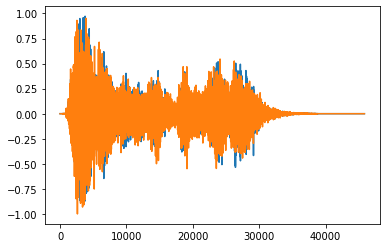

In [2]:
rate, file = read("lecture1300ms.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

plt.plot(data0)
plt.plot(data1)
plt.show()

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    xn = np.append(np.zeros(128), xn)
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

In [4]:
def gaussian():
    R1 = random.random()
    R2 = random.random()
    return np.sqrt(-2 * np.log(R1)) * np.cos(2*pi*R2)

In [5]:
M = 512
H = 128
W = signal.get_window("hamming", M)

noise = []
for index in range(len(data0)):
    noise.append(gaussian() * np.power(10, (-150 / 20))) 

data0 = data0 + noise 
data1 = data1 + noise

dataSet0, data0, length, iteration = PreProcessData(data0, M, H)
dataSet1, data1, length, iteration = PreProcessData(data1, M, H)

width = np.exp(np.pi * 0.9 * np.complex128(1j))
rms = np.sqrt(2) * 0.5 * H / M

In [6]:
DC = np.zeros(length)

for index in range(iteration):
    
    fL = np.fft.fft(dataSet0[index] * W)
    fR = np.fft.fft(dataSet1[index] * W)
    
    distance = np.sqrt(np.abs(fL) ** 2 + np.abs(fR) ** 2)
    
    aL = np.abs(fL) / (distance)
    aR = np.abs(fR) / (distance)

    direct = np.zeros(M, dtype = np.complex128)
    dc_mag = np.zeros(M, dtype = np.complex128)
    dc =     np.zeros(M, dtype = np.complex128)
    
    direct = (fL * width - fR) / (aL * width - aR)
    
    dl = direct * aL
    dr = direct * aR
    nl = fL - dl
    nr = fR - dr
    
    dc_mag = rms * ( np.abs(dl + dr) - np.abs(dl - dr))

    dc = ((dl + dr) * dc_mag) / (np.abs(dl + dr))

    start = index * H
    end = start + M
    
    DC[start : end] = DC[start : end] + np.fft.ifft(dc).real * W

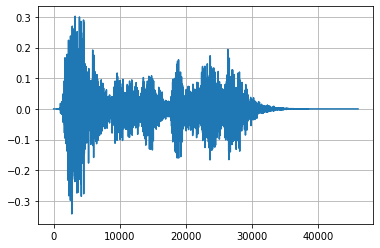

In [7]:
numerator= [1, -1]
denominator = [1, -0.95]

DC = signal.lfilter(numerator, denominator, DC)

plt.plot(DC)
plt.grid()
plt.show()

In [8]:
write("DC.wav", rate, (DC * 32767.0).astype(np.int16))

IPython.display.display(IPython.display.Audio("DC.wav", rate=rate))
IPython.display.display(IPython.display.Audio("lecture1300ms.wav", rate=rate))